In [98]:
import re, nltk, spacy, codecs, requests
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from textblob import TextBlob
from bs4 import BeautifulSoup as bs
from tqdm import tqdm_notebook
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Multi-page web-scraping

In [99]:
h = {'authority': 'www.amazon.in',
     'accept-language': 'en-US,en;q=0.9',
     'referer': 'https://www.amazon.in/boAt-Xtend-Pro-Dedicated-Bluetooth/dp/B0B574QXFL/ref=sr_1_3?adgrpid=66314740727&ext_vrnc=hi&gclid=CjwKCAiAheacBhB8EiwAItVO27OqojMgIrqr8l4RkhJXVEgEYEy5H4Hv_ggVfrdU-8RF6WYv_aDItRoCKvwQAvD_BwE&hvadid=398059830400&hvdev=c&hvlocphy=1007768&hvnetw=g&hvqmt=b&hvrand=1335892987492695214&hvtargid=kwd-1434352673191&hydadcr=24569_1971431&keywords=boat+xtend+pro&qid=1671035479&sr=8-3',
     'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
#header

In [100]:
def get_soup(url):
    r = requests.get(url, headers=h, params={'url': url, 'wait': 2})
    return bs(r.text, 'html.parser')

In [101]:
reviewlist = []

def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    for item in reviews:
        review = {'Title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
                  'Rating': float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
                  'Review': item.find('span', {'data-hook': 'review-body'}).text.strip(),
                  'Review_Date': item.find('span', {'data-hook': 'review-date'}).text.replace('Reviewed in India 🇮🇳 on', 'Reviewed in India on').strip()}
        reviewlist.append(review)



In [102]:
for x in tqdm_notebook(range(160)):
    url = f'https://www.amazon.in/boAt-Xtend-Pro-Dedicated-Bluetooth/product-reviews/B0B574QXFL/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={x}'
    soup = get_soup(url)
    get_reviews(soup)
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break


<ipython-input-102-e698bd545e40>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x in tqdm_notebook(range(160)):


  0%|          | 0/160 [00:00<?, ?it/s]

In [103]:
df = pd.DataFrame(reviewlist)
df['Review_Date'] = df['Review_Date'].str.replace('Reviewed in India on', '', regex=True)
df.head(15)
df.to_csv("BoatSmartWatch_Review.csv", index=False)

# Loading Dataset

In [104]:
# Load the dataset and drop the 'Unnamed: 0' column
reviews = pd.read_csv('BoatSmartWatch_Review.csv')#.drop('Unnamed: 0', axis=1)
# Display the dataset
reviews

,Title,Rating,Review,Review_Date
0,3.0 out of 5 stars\nNOt worth the money,3.0,Review OverviewAverage2.7The Boat today launch...,17 May 2022
1,5.0 out of 5 stars\nBest Budget watch,5.0,The media could not be loaded.\n ...,12 August 2021
2,3.0 out of 5 stars\nGood build quality & displ...,3.0,Skipping the parts mostly covered in other rev...,9 August 2022
3,4.0 out of 5 stars\nGood product.,4.0,This smart (model Boat extend plus) watch is f...,27 August 2023
4,4.0 out of 5 stars\nGood budget smart watch wi...,4.0,Pros:1. Premium build quality with matte finis...,16 December 2021
...,...,...,...,...
105,4.0 out of 5 stars\nNice,4.0,Nice,31 July 2023
106,4.0 out of 5 stars\nGood,4.0,Good product go for it.,24 August 2023
107,4.0 out of 5 stars\nNice product,4.0,Nice display,7 August 2023
108,"4.0 out of 5 stars\nIt's a medium size, light ...",4.0,Overall it's good and I got it at the price of...,18 August 2023


Data Exploration

In [105]:
reviews['Rating'].describe()

count    110.000000
mean       3.890909
std        0.475943
min        3.000000
25%        4.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Rating, dtype: float64

In [106]:
reviews.isna().sum()

Title          0
Rating         0
Review         2
Review_Date    0
dtype: int64

In [107]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        110 non-null    object 
 1   Rating       110 non-null    float64
 2   Review       108 non-null    object 
 3   Review_Date  110 non-null    object 
dtypes: float64(1), object(3)
memory usage: 3.6+ KB


In [108]:
# Remove rows with missing 'Review' values and display the updated DataFrame
reviews.dropna(subset=['Review'], inplace=True)
reviews.head()

,Title,Rating,Review,Review_Date
0,3.0 out of 5 stars\nNOt worth the money,3.0,Review OverviewAverage2.7The Boat today launch...,17 May 2022
1,5.0 out of 5 stars\nBest Budget watch,5.0,The media could not be loaded.\n ...,12 August 2021
2,3.0 out of 5 stars\nGood build quality & displ...,3.0,Skipping the parts mostly covered in other rev...,9 August 2022
3,4.0 out of 5 stars\nGood product.,4.0,This smart (model Boat extend plus) watch is f...,27 August 2023
4,4.0 out of 5 stars\nGood budget smart watch wi...,4.0,Pros:1. Premium build quality with matte finis...,16 December 2021


Data Visualization

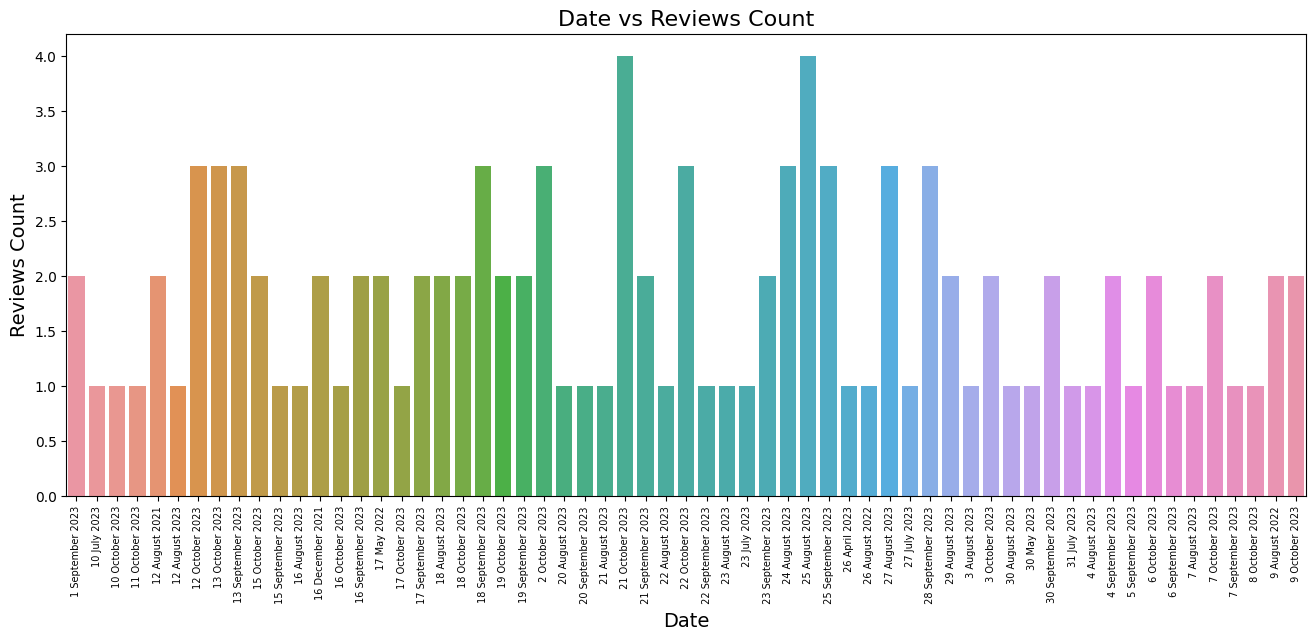

In [109]:
# Create a DataFrame 'dayreview' by grouping reviews by 'Review_Date' and counting the reviews
dayreview = pd.DataFrame(reviews.groupby('Review_Date')['Review'].count()).reset_index()
dayreview['Date'] = dayreview['Review_Date']
dayreview.sort_values(by=['Review_Date'])

# Plot a bar graph to visualize the number of reviews by date
plt.figure(figsize=(16, 6))
sns.barplot(x="Date", y="Review", data=dayreview)
plt.title('Date vs Reviews Count', fontsize=16)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Reviews Count', fontsize=14)
plt.show()


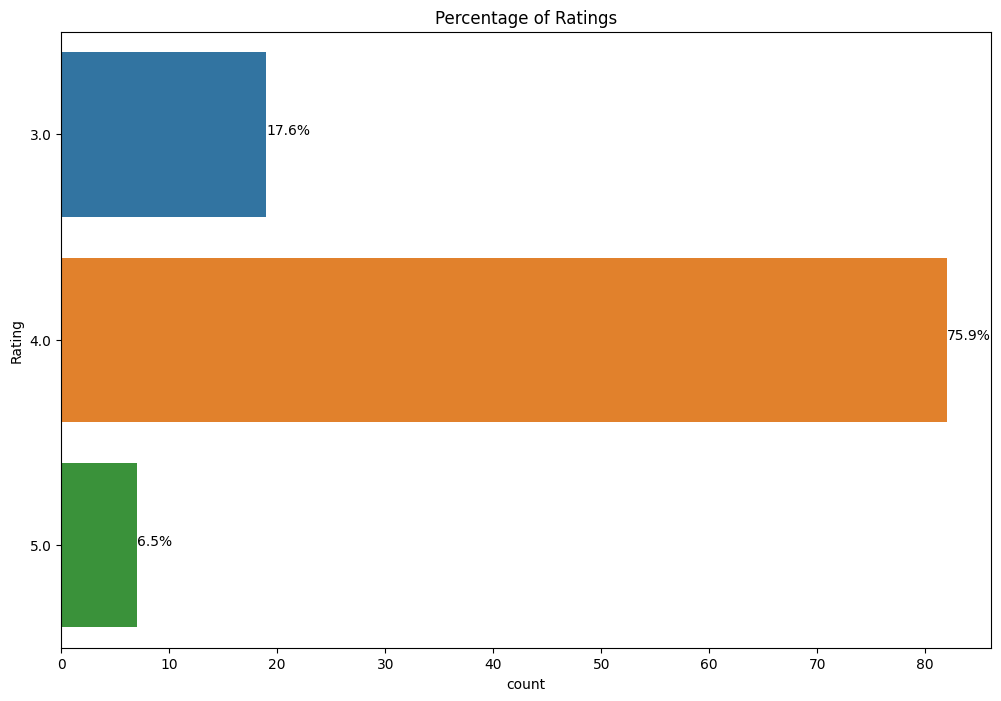

In [110]:
plt.figure(figsize=(12, 8))
plt.title('Percentage of Ratings')
ax = sns.countplot(y='Rating', data=reviews)
total = len(reviews)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y))


Text Preprocessing

In [111]:
reviews['Review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    Review OverviewAverage2.The Coat today launche...
1    The media could not be loaded.\n              ...
2    Shipping the parts mostly covered in other rev...
3    His smart (model Coat extend plus) watch is sa...
4    Gros:1. Premium build quality with matter fini...
Name: Review, dtype: object

In [112]:
boat_review = reviews[['Review']]
boat_review

,Review
0,Review OverviewAverage2.7The Boat today launch...
1,The media could not be loaded.\n ...
2,Skipping the parts mostly covered in other rev...
3,This smart (model Boat extend plus) watch is f...
4,Pros:1. Premium build quality with matte finis...
...,...
105,Nice
106,Good product go for it.
107,Nice display
108,Overall it's good and I got it at the price of...


In [113]:
boat_review.reset_index(drop=True, inplace=True)

In [114]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [115]:
stop_words = stopwords.words('english')
boat_review['Review'] = boat_review['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop_words))


<ipython-input-115-c2ff89cf1036>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boat_review['Review'] = boat_review['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop_words))


In [116]:
lemmatizer = WordNetLemmatizer()


In [117]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [118]:
corpus = []
for i in tqdm_notebook(range(0, len(boat_review))):
    cleaned = re.sub('[^a-zA-Z]', ' ', boat_review['Review'][i])
    cleaned = cleaned.lower()
    cleaned = cleaned.split()
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)


<ipython-input-118-730d2bc07567>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(boat_review))):


  0%|          | 0/108 [00:00<?, ?it/s]

In [119]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making text lowercase, applying Lemmatizer, Removing Stop words
corpus = []
for i in tqdm_notebook(range(0, len(boat_review))):

    cleaned = re.sub('[^a-zA-Z]', ' ', boat_review['Review'][i])
    cleaned = cleaned.lower()
    cleaned = cleaned.split()
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words('english')]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)


<ipython-input-119-8ebae488b390>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(boat_review))):


  0%|          | 0/108 [00:00<?, ?it/s]

In [120]:
# Creating a DataFrame for comparison
dataframe = pd.DataFrame({"Clean_Reviews": corpus, "Original_Reviews": boat_review['Review']})
dataframe.head()

,Clean_Reviews,Original_Reviews
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...


In [121]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)

    return text


In [122]:
# Remove Twitter handles and store the result in a new column 'Clean_Reviews'
dataframe['Clean_Reviews'] = np.vectorize(remove_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)


,Clean_Reviews,Original_Reviews
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...
5,boat watch record distance compared phone way ...,boat watch records distance compared phone. is...
6,battery drain fastdoesn last even full day,the battery drains fastdoesn't last even full day
7,good product useful,good product useful....👌👍💪
8,good,good
9,really like product durable sound quality also...,"i really like product, durable, sound quality ..."


In [123]:
cleaned_reviews = []

for index, row in dataframe.iterrows():
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)


,Clean_Reviews,Original_Reviews
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...
5,boat watch record distance compared phone way ...,boat watch records distance compared phone. is...
6,battery drain fastdoesn last even full day,the battery drains fastdoesn't last even full day
7,good product useful,good product useful....👌👍💪
8,good,good
9,really like product durable sound quality also...,"i really like product, durable, sound quality ..."


In [124]:
dataframe = dataframe[dataframe['Clean_Reviews'] != '']
dataframe.head(10)


,Clean_Reviews,Original_Reviews
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...
5,boat watch record distance compared phone way ...,boat watch records distance compared phone. is...
6,battery drain fastdoesn last even full day,the battery drains fastdoesn't last even full day
7,good product useful,good product useful....👌👍💪
8,good,good
9,really like product durable sound quality also...,"i really like product, durable, sound quality ..."


In [125]:
from google.colab import files
upload=files.upload()

Saving negative-words.txt to negative-words (1).txt
Saving positive-words.txt to positive-words (1).txt
Saving stop.txt to stop (1).txt


In [126]:
with codecs.open("stop.txt", "r", encoding="ISO-8859-1") as s:
    stop = s.read()
    print(stop[:101])


a
a's
able
about
above
according
accordingly
across
actually
after
afterwards
again
again


In [127]:
stop.split(" ")


["a\r\na's\r\nable\r\nabout\r\nabove\r\naccording\r\naccordingly\r\nacross\r\nactually\r\nafter\r\nafterwards\r\nagain\r\nagainst\r\nain't\r\nall\r\nallow\r\nallows\r\nalmost\r\nalone\r\nalong\r\nalready\r\nalso\r\nalthough\r\nalways\r\nam\r\namong\r\namongst\r\nan\r\nand\r\nanother\r\nany\r\nanybody\r\nanyhow\r\nanyone\r\nanything\r\nanyway\r\nanyways\r\nanywhere\r\napart\r\nappear\r\nappreciate\r\nappropriate\r\nare\r\naren't\r\naround\r\nas\r\naside\r\nask\r\nasking\r\nassociated\r\nat\r\navailable\r\naway\r\nawfully\r\nb\r\nbe\r\nbecame\r\nbecause\r\nbecome\r\nbecomes\r\nbecoming\r\nbeen\r\nbefore\r\nbeforehand\r\nbehind\r\nbeing\r\nbelieve\r\nbelow\r\nbeside\r\nbesides\r\nbest\r\nbetter\r\nbetween\r\nbeyond\r\nboth\r\nbrief\r\nbut\r\nby\r\nc\r\nc'mon\r\nc's\r\ncame\r\ncan\r\ncan't\r\ncannot\r\ncant\r\ncause\r\ncauses\r\ncertain\r\ncertainly\r\nchanges\r\nclearly\r\nco\r\ncom\r\ncome\r\ncomes\r\nconcerning\r\nconsequently\r\nconsider\r\nconsidering\r\ncontain\r\ncontaining\r\nconta

In [128]:
my_stop_words = stopwords.words('english')
sw_list = [stop]
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)

cleaned_reviews = []

for index, row in dataframe.iterrows():
    words_without_stopwords = [word for word in row.Clean_Reviews.split() if word.lower() not in stopwords_set and '#' not in word]
    cleaned_reviews.append(' '.join(words_without_stopwords))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)


,Clean_Reviews,Original_Reviews
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...
5,boat watch record distance compared phone way ...,boat watch records distance compared phone. is...
6,battery drain fastdoesn last even full day,the battery drains fastdoesn't last even full day
7,good product useful,good product useful....👌👍💪
8,good,good
9,really like product durable sound quality also...,"i really like product, durable, sound quality ..."


In [129]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [130]:
TextBlob(dataframe['Clean_Reviews'][1]).words

WordList(['medium', 'could', 'loaded', 'used', 'watch', 'month', 'bought', 'first', 'sale', 'keep', 'reading', 'unbiased', 'review', 'tip', 'trick', 'ensure', 'function', 'watch', 'working', 'smoothly', 'large', 'curved', 'display', 'price', 'category', 'inch', 'battery', 'heavy', 'usage', 'frequently', 'waking', 'screen', 'alexa', 'alarm', 'notification', 'day', 'standby', 'checking', 'time', 'occassionally', 'day', 'pretty', 'good', 'full', 'charging', 'time', 'hour', 'decent', 'quality', 'magnetic', 'charging', 'cable', 'provided', 'use', 'low', 'power', 'adapter', 'power', 'bank', 'laptop', 'necessary', 'health', 'workout', 'tracking', 'option', 'spo', 'oxymeter', 'heart', 'rate', 'monitor', 'accuracy', 'sleep', 'tracking', 'pretty', 'accurate', 'paedometer', 'accurate', 'time', 'sometimes', 'hundred', 'step', 'added', 'randomly', 'without', 'activity', 'happens', 'randomly', 'day', 'stress', 'monitor', 'also', 'sure', 'calculated', 'sensor', 'fake', 'probably', 'watch', 'contact',

In [131]:
tokenized_review = dataframe['Clean_Reviews'].apply(lambda x: x.split())
tokenized_review.head(10)

0    [review, overviewaverage, boat, today, launche...
1    [medium, could, loaded, used, watch, month, bo...
2    [skipping, part, mostly, covered, review, spon...
3    [smart, model, boat, extend, plus, watch, func...
4    [pro, premium, build, quality, matte, finishin...
5    [boat, watch, record, distance, compared, phon...
6    [battery, drain, fastdoesn, last, even, full, ...
7                              [good, product, useful]
8                                               [good]
9    [really, like, product, durable, sound, qualit...
Name: Clean_Reviews, dtype: object

In [132]:
dataframe['Tokenized_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)


,Clean_Reviews,Original_Reviews,Tokenized_Reviews
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...,"[review, overviewaverage, boat, today, launche..."
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....,"[medium, could, loaded, used, watch, month, bo..."
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...,"[skipping, part, mostly, covered, review, spon..."
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...,"[smart, model, boat, extend, plus, watch, func..."
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...,"[pro, premium, build, quality, matte, finishin..."
5,boat watch record distance compared phone way ...,boat watch records distance compared phone. is...,"[boat, watch, record, distance, compared, phon..."
6,battery drain fastdoesn last even full day,the battery drains fastdoesn't last even full day,"[battery, drain, fastdoesn, last, even, full, ..."
7,good product useful,good product useful....👌👍💪,"[good, product, useful]"
8,good,good,[good]
9,really like product durable sound quality also...,"i really like product, durable, sound quality ...","[really, like, product, durable, sound, qualit..."


In [133]:
word_lemmatizer = WordNetLemmatizer()
yy = pd.DataFrame()
yy['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
yy

,stemmed
0,review overviewaverage boat today launched boa...
1,medium could loaded used watch month bought fi...
2,skipping part mostly covered review sponsored ...
3,smart model boat extend plus watch functioning...
4,pro premium build quality matte finishing stur...
...,...
103,nice
104,good product go
105,nice display
106,overall good got price battery life also good


Feature Extaction

In [134]:
cv = CountVectorizer()
tweets_cv = cv.fit_transform(dataframe['Clean_Reviews'])

In [135]:
print(cv.get_feature_names_out()[109:200])
print(cv.get_feature_names_out()[:100])
print(tweets_cv.toarray()[100:200])


['beautiful' 'become' 'bed' 'beginning' 'believe' 'beneficial' 'best'
 'better' 'beyond' 'bezel' 'bezzels' 'bhi' 'big' 'bike' 'bip' 'bit'
 'black' 'bloated' 'blood' 'bluetooth' 'boat' 'body' 'bother' 'bought'
 'box' 'bp' 'break' 'breath' 'breathing' 'bright' 'brightness' 'brings'
 'brother' 'browsing' 'brushed' 'bt' 'budget' 'bug' 'build' 'buildi'
 'built' 'bulb' 'burned' 'burnt' 'busy' 'button' 'buy' 'buying' 'cable'
 'cache' 'calculated' 'calculation' 'calculator' 'calender' 'call'
 'called' 'caller' 'calling' 'calorie' 'calory' 'cals' 'camera' 'cannot'
 'capability' 'carddesign' 'care' 'case' 'category' 'catering' 'caters'
 'caused' 'center' 'centerbefore' 'certain' 'change' 'changed' 'changer'
 'charge' 'charger' 'charging' 'charm' 'cheap' 'cheaper' 'cheating'
 'check' 'checked' 'checking' 'childish' 'chinese' 'choice' 'claim']
['absolutely' 'ac' 'accept' 'acceptable' 'acceptance' 'accepts' 'access'
 'accessibility' 'accessible' 'accessory' 'accidentally' 'account'
 'accuracy' 'acc

In [136]:
dataframe = dataframe.reset_index(drop=True)
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):

    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

cv = CountVectorizer(max_features=1546, ngram_range=(1, 3))
X = cv.fit_transform(corpus).toarray()
X.shape

cv.get_feature_names_out()[:20]

cv.get_params()

count_df = pd.DataFrame(X, columns=cv.get_feature_names_out())
count_df


<ipython-input-136-c7a2279f2ce1>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(dataframe))):


  0%|          | 0/106 [00:00<?, ?it/s]

,absolut,accept,access,accur,accuraci,accuraci sleep,accuraci sleep track,activ,activ step,actual,...,would recommend go,wrist,xtend,xtend plu,xtend smartwatch,xtend watch,ye,year,yet,yt
0,0,0,1,4,3,0,0,1,0,0,...,2,0,20,0,7,1,1,0,0,0
1,0,0,0,3,1,1,1,3,0,1,...,0,0,1,0,0,1,1,0,0,0
2,0,1,1,0,1,0,0,6,1,1,...,0,1,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,1,1,0,...,0,1,0,0,0,0,2,0,1,0
4,1,3,0,3,1,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()

    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

tfidf_v = TfidfVectorizer(max_features=1546)
X = tfidf_v.fit_transform(corpus).toarray()
X.shape
tfidf_v.get_feature_names_out()[:20]
tfidf_v.get_params()
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names_out())
count_df


<ipython-input-137-f80d64deb780>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(0, len(dataframe))):


  0%|          | 0/106 [00:00<?, ?it/s]

,absolut,ac,accept,access,accessori,accident,account,accur,accuraci,accuracybatteryy,...,wrist,wristwear,wud,xtend,ye,year,yet,yoga,yr,yt
0,0.000000,0.000000,0.000000,0.016033,0.0,0.000000,0.000000,0.064131,0.041984,0.021101,...,0.000000,0.0,0.0,0.343841,0.016576,0.0,0.00000,0.0,0.000000,0.000000
1,0.000000,0.035551,0.000000,0.000000,0.0,0.035551,0.035551,0.081038,0.023579,0.000000,...,0.000000,0.0,0.0,0.028966,0.027928,0.0,0.00000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.033694,0.028820,0.0,0.000000,0.000000,0.000000,0.025156,0.000000,...,0.028820,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.037929,0.035544
3,0.000000,0.000000,0.000000,0.042479,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042479,0.0,0.0,0.000000,0.087837,0.0,0.05239,0.0,0.000000,0.000000
4,0.037125,0.000000,0.105578,0.000000,0.0,0.000000,0.000000,0.090306,0.026275,0.000000,...,0.030102,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
102,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
103,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
104,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000


In [138]:
reviews = [review.strip() for review in dataframe.Clean_Reviews]
reviews = [comment for comment in reviews if comment]
reviews_text = ' '.join(reviews)
print(reviews_text[:2000])

review overviewaverage boat today launched boat xtend company latest budget smartwatch price tag r boat xtend smartwatch come stylish design resembling apple watch moreover built amazon alexa support spo tracking stress tracking much coming budget segment worth buy smartwatch query nothing worry detailed review boat xtend smartwatch clear doubt contentsbox contentdesign build comfortdisplaywatch ui featuresalexa supportwatch facesboat wave appaccuracybatteryfinal wordsbuy box contentboat xtend box contentsmartwatch black gold colourcharging clipuser manual warranty carddesign build comfortwhen buying smartwatch one always think design look apart feature design build another major aspect one take care buying smartwatch boat worked design time brings premium side term look design inspired apple watch cannot compared obviously every aspect apple watch would much better boat xtend smartwatch redmi watch well amazfit bip u pro shape design build quality much premium one boat xtend design bu

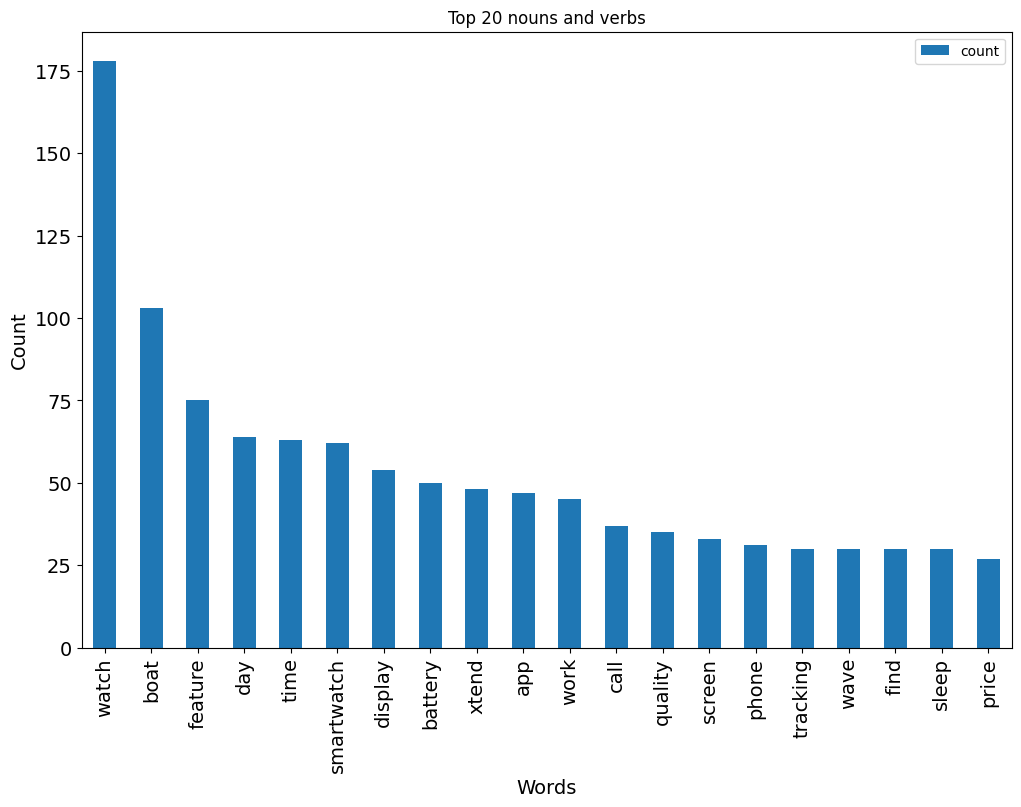

In [139]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Process the entire text
doc_block = nlp(reviews_text)

# Extract nouns and verbs
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN', 'VERB')]

# Create a CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)

# Count word frequencies
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]

# Sort by frequency
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Create a DataFrame
wd_df = pd.DataFrame(words_freq, columns=['word', 'count'])

# Plot the top 10 nouns and verbs
wd_df.head(20).plot.bar(x='word', figsize=(12, 8), title='Top 20 nouns and verbs', fontsize=14, rot=90)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


Feature Extraction

In [140]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create a Bag of Words (BoW) feature matrix
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

# Create a TF-IDF feature matrix
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])


TextBlob Sentiments: Positive, Neutral, Negative.

In [141]:
from textblob import TextBlob

# Function to fetch sentiment
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

# Apply the sentiment function to the cleaned reviews
sentiments_using_textblob = dataframe['Clean_Reviews'].apply(fetch_sentiment_using_textblob)

# Count the occurrences of each sentiment
sentiment_counts = sentiments_using_textblob.value_counts()

# Create a DataFrame to display sentiment counts
sentiment_df = pd.DataFrame(sentiment_counts)

# Rename the columns for clarity
sentiment_df.columns = ['Sentiment Count']

# Display the DataFrame
sentiment_df


,Sentiment Count
pos,101
neg,5


In [142]:
from textblob import TextBlob

# Function to calculate subjectivity
def calc_subj(text):
    return TextBlob(text).sentiment.subjectivity

# Function to calculate polarity
def calc_pola(text):
    return TextBlob(text).sentiment.polarity

# Calculate subjectivity and polarity for each review
dataframe['Subjectivity'] = dataframe['Clean_Reviews'].apply(calc_subj)
dataframe['Polarity'] = dataframe['Clean_Reviews'].apply(calc_pola)

# Display the DataFrame with subjectivity and polarity columns
dataframe.head()


,Clean_Reviews,Original_Reviews,Tokenized_Reviews,Subjectivity,Polarity
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...,"[review, overviewaverage, boat, today, launche...",0.427641,0.202171
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....,"[medium, could, loaded, used, watch, month, bo...",0.472013,0.129274
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...,"[skipping, part, mostly, covered, review, spon...",0.441033,-0.001266
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...,"[smart, model, boat, extend, plus, watch, func...",0.450855,0.320452
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...,"[pro, premium, build, quality, matte, finishin...",0.533112,0.292296


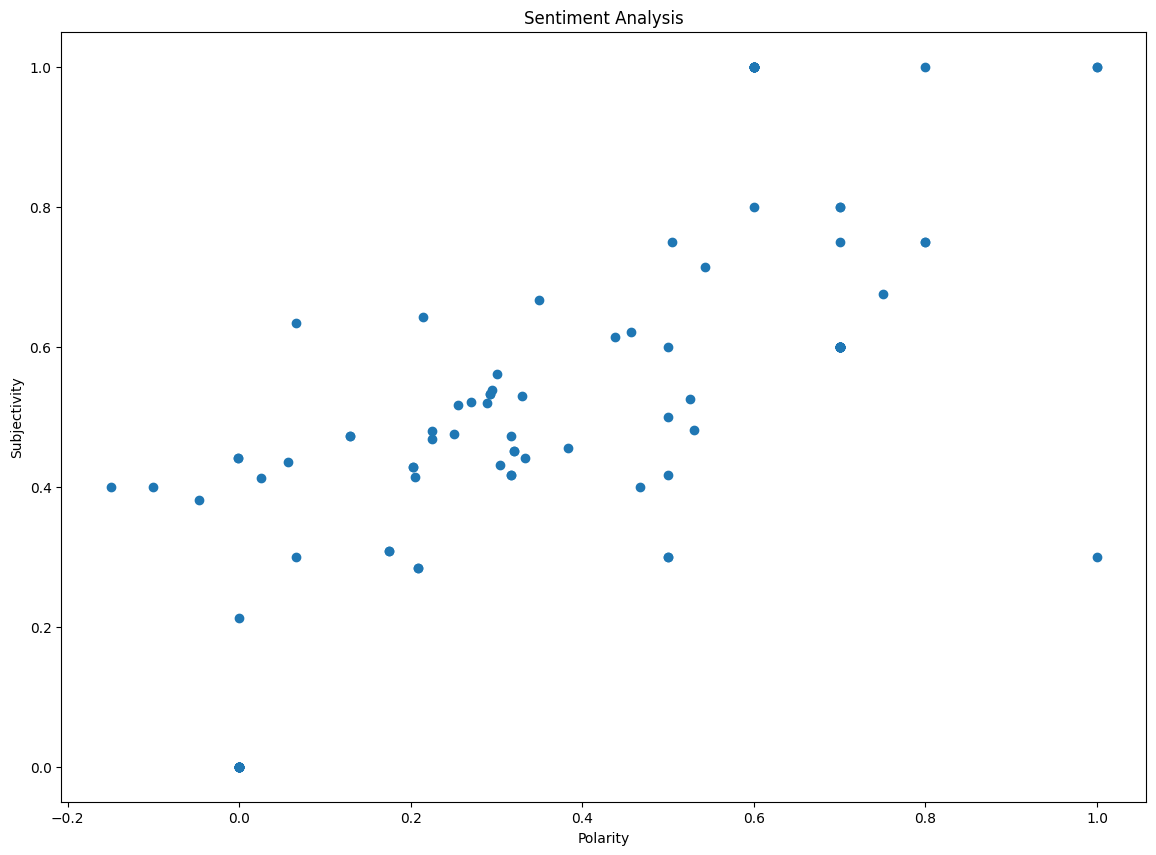

In [143]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(14, 10))
plt.scatter(dataframe['Polarity'], dataframe['Subjectivity'])
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Show the plot
plt.show()


In [144]:
dataframe['sentiment'] = sentiments_using_textblob
dataframe.to_csv("clean_review.csv", index=False)
dataframe.head()

,Clean_Reviews,Original_Reviews,Tokenized_Reviews,Subjectivity,Polarity,sentiment
0,review overviewaverage boat today launched boa...,review overviewaverage2.7the boat today launch...,"[review, overviewaverage, boat, today, launche...",0.427641,0.202171,pos
1,medium could loaded used watch month bought fi...,the media could loaded. used watch month now.....,"[medium, could, loaded, used, watch, month, bo...",0.472013,0.129274,pos
2,skipping part mostly covered review sponsored ...,skipping parts mostly covered reviews sponsore...,"[skipping, part, mostly, covered, review, spon...",0.441033,-0.001266,neg
3,smart model boat extend plus watch functioning...,this smart (model boat extend plus) watch func...,"[smart, model, boat, extend, plus, watch, func...",0.450855,0.320452,pos
4,pro premium build quality matte finishing stur...,pros:1. premium build quality matte finishing-...,"[pro, premium, build, quality, matte, finishin...",0.533112,0.292296,pos


 Visualization

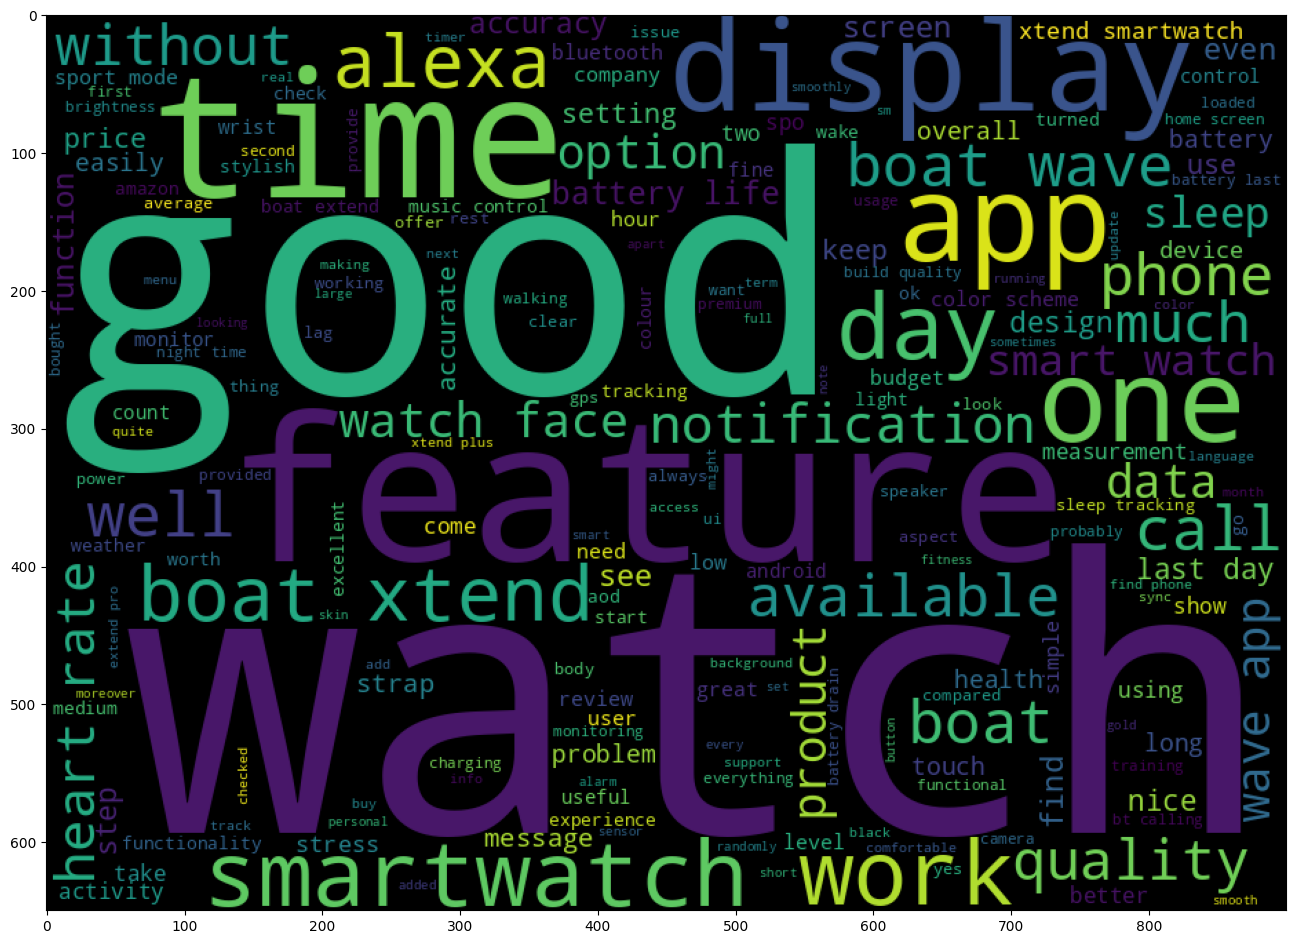

In [145]:
allWords_ = ' '.join(dataframe['Clean_Reviews'][:250])
wordcloud = WordCloud(background_color='black', width=900, height=650).generate(allWords_)

plt.figure(figsize=(16, 12))
plt.imshow(wordcloud)


Positive words

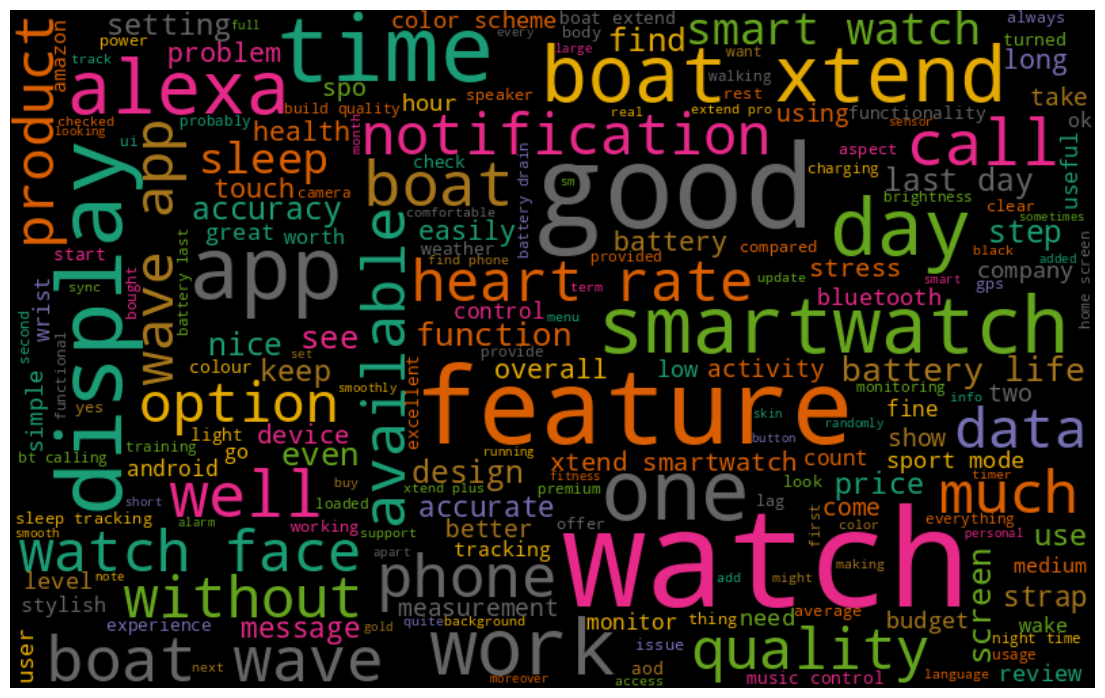

In [146]:
# Generate a Word Cloud with Modified Stop Words

from wordcloud import WordCloud

# Define a function to generate the Word Cloud
def generate_wordcloud(all_words):
    # Generate the Word Cloud with custom parameters
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    # Display the Word Cloud
    plt.figure(figsize=(14,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Combine all cleaned reviews into a single text
all_words = ' '.join(dataframe['Clean_Reviews'])

# Generate and display the Word Cloud
generate_wordcloud(all_words)


Negative words

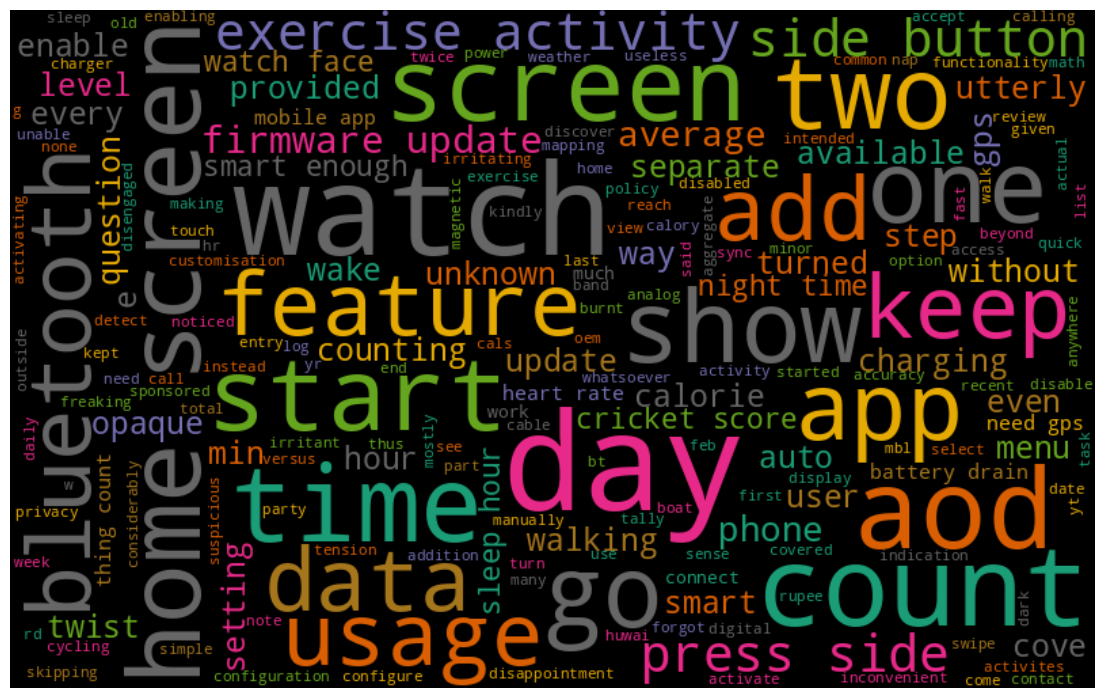

In [147]:
# Generate a Word Cloud for Negative Sentiment Reviews

# Combine all cleaned reviews with negative sentiment into a single text
negative_reviews = ' '.join(dataframe['Clean_Reviews'][dataframe.sentiment == 'neg'])

# Generate and display the Word Cloud
generate_wordcloud(negative_reviews)
